In [2]:
!pip install gdcm
!pip install pylibjpeg-libjpeg
!pip install pylibjpeg

     |████████████████████████████████| 2.7 MB 28.8 MB/s eta 0:00:01
     |████████████████████████████████| 4.3 MB 36.8 MB/s eta 0:00:01


In [2]:
from fastai.vision.all import *
from fastai.medical.imaging import *
import warnings
warnings.filterwarnings('ignore')

In [3]:
path = Path('./New Data/train-Data/train/')

In [4]:
dblock = DataBlock(
    blocks=(ImageBlock(cls=PILDicom), CategoryBlock),
    get_items=get_dicom_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(512),
    batch_tfms=[IntToFloatTensor()]
    )

In [5]:
dls = dblock.dataloaders(path, bs = 16, num_workers=0)

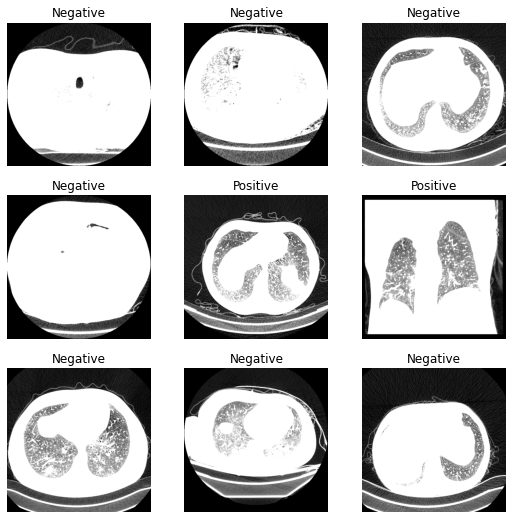

In [6]:
dls.train.show_batch(max_n=9, nrows=3)

In [7]:
len(dls.train_ds), len(dls.valid_ds)

(11378, 2844)

In [9]:
mixup = MixUp(0.5)

In [10]:
learn = cnn_learner(dls, resnet50, loss_func=LabelSmoothingCrossEntropy(), metrics=[accuracy, 
                    Precision(), Recall(), F1Score()], cbs = mixup).to_fp16()

In [11]:
learn.opt_func

<function fastai.optimizer.Adam(params, lr, mom=0.9, sqr_mom=0.99, eps=1e-05, wd=0.01, decouple_wd=True)>

SuggestedLRs(valley=0.0030199517495930195)

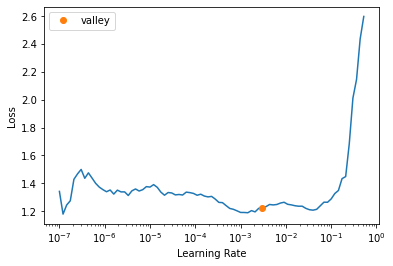

In [12]:
learn.lr_find()

In [13]:
learn.fine_tune(epochs=1,
          base_lr=0.0030199517495930195,
          cbs=[SaveModelCallback(monitor='f1_score')])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.505773,0.320378,0.938819,0.992206,0.885873,0.936029,05:17


Better model found at epoch 0 with f1_score value: 0.9360294117647059.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.364423,0.208249,0.999297,1.000000,0.998608,0.999304,05:37


Better model found at epoch 0 with f1_score value: 0.9993036211699164.


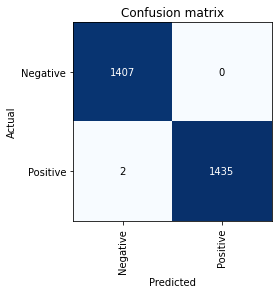

In [14]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [15]:
learn.unfreeze()
learn.fit_one_cycle(n_epoch=2, lr_max=0.0030199517495930195)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.519283,0.346597,0.928270,0.963186,0.892136,0.926301,05:36
1,0.394994,0.215977,0.998594,0.997224,1.000000,0.998610,05:36


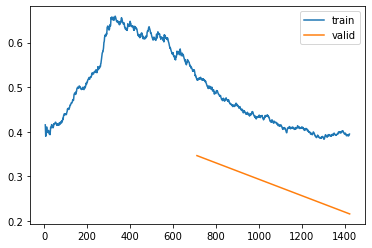

In [16]:
learn.recorder.plot_loss()

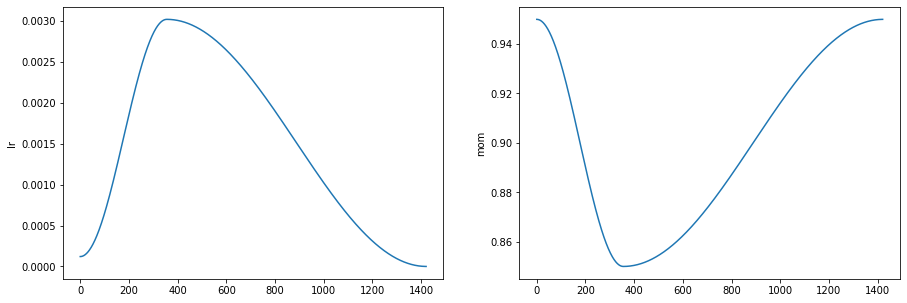

In [17]:
learn.recorder.plot_sched(figsize=(15,5))

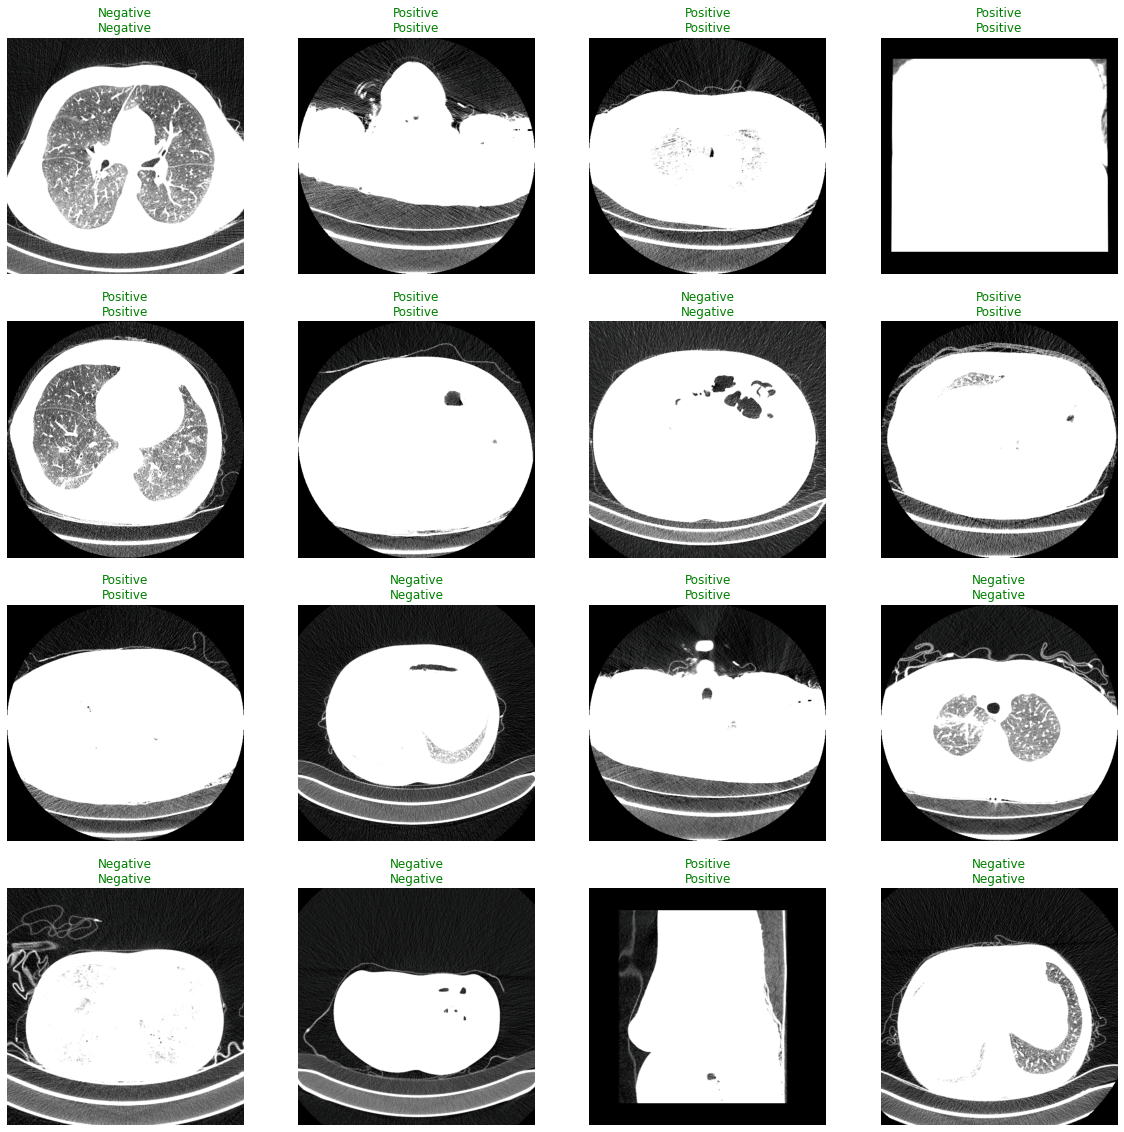

In [18]:
learn.show_results(max_n=16,figsize=(20,20))

In [19]:
test_path = './New Data/test-Data/test/'
test_files = get_dicom_files(test_path)
test_files

(#3406) [Path('New Data/test-Data/test/Negative/2.000000-62502-1-097.dcm'),Path('New Data/test-Data/test/Negative/2.000000-55762-1-023.dcm'),Path('New Data/test-Data/test/Negative/2.000000-57539-1-018.dcm'),Path('New Data/test-Data/test/Negative/2.000000-58080-1-182.dcm'),Path('New Data/test-Data/test/Negative/3.000000-58887-1-108.dcm'),Path('New Data/test-Data/test/Negative/3.000000-56570-1-170.dcm'),Path('New Data/test-Data/test/Negative/3.000000-56570-1-130.dcm'),Path('New Data/test-Data/test/Negative/2.000000-57539-1-162.dcm'),Path('New Data/test-Data/test/Negative/3.000000-60317-1-178.dcm'),Path('New Data/test-Data/test/Negative/3.000000-61865-1-197.dcm')...]

In [20]:
len(test_files)

3406

In [21]:
test_dls = dls.test_dl(test_files, bs = 16, with_labels=True) #holdout set

In [22]:
test_interp = ClassificationInterpretation.from_learner(learn, dl=test_dls)

              precision    recall  f1-score   support

    Negative       0.69      0.48      0.56      2085
    Positive       0.44      0.65      0.53      1321

    accuracy                           0.55      3406
   macro avg       0.56      0.57      0.55      3406
weighted avg       0.59      0.55      0.55      3406



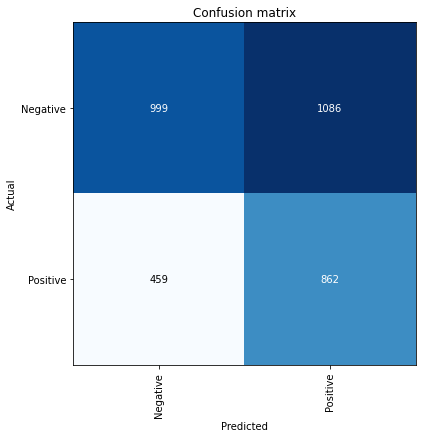

In [23]:
test_interp.print_classification_report()
test_interp.plot_confusion_matrix(figsize=(6,6))

In [1]:
!nvidia-smi

Thu Jan 27 06:04:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  RTX A4000           Off  | 00000000:00:05.0 Off |                  Off |
| 41%   39C    P8    17W / 140W |      0MiB / 16117MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#import torch
#torch.cuda.empty_cache()